Install Packages

In [1]:
!pip install timm==0.3.2
!pip install torch==1.8.1

     |████████████████████████████████| 244 kB 11.9 MB/s 
     |████████████████████████████████| 804.1 MB 2.8 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu111 requires torch==1.9.0, but you have torch 1.8.1 which is incompatible.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.8.1 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import requests
import timm
from PIL import Image
from torchsummary import summary
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import pandas as pd
from torch.utils.data import Dataset
from sklearn.datasets import load_diabetes

In [14]:
#dataset paths
data_jaffe = '/content/drive/MyDrive/jaffe'
data_KDEF = "/content/drive/MyDrive/KDEF_ex"

In [8]:
def random_colour_space(x):
  output = x.convert("HSV")
  return output
colour_transform = transforms.Lambda(lambda x: random_colour_space(x))

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [15]:
#define datatransformations

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(384),
        transforms.RandomApply([colour_transform]),
        transforms.RandomAffine(degrees= 30),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(384),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


Data Loaders

In [16]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_KDEF, x),
                                          data_transforms[x])
                  for x in ['train','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=2)
              for x in ['train','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
dataset_sizes

{'train': 3910, 'val': 979}

In [18]:
len(dataloaders['train'])

245

In [19]:
for i in class_names:
  print(i)

afraid
angry
disgust
happy
neutral
sad
surprise


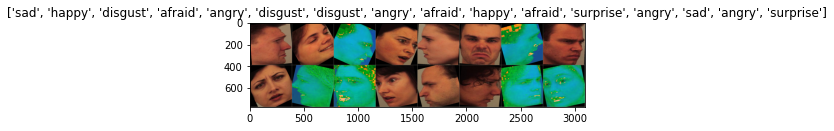

In [20]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

#show sample images from dataset
imshow(out, title=[class_names[x] for x in classes])

In [21]:
#Training funciton

def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train':
            #     scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # for param_group in optimizer.param_groups:
            #   print('learning rate:-', param_group['lr'])
            

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'val':              
              print('Best val Acc till now: {:4f}'.format(best_acc))

            #for every 50 epochs save the model
            if epoch % 50 == 49:
              
              torch.save(model,'/content/drive/MyDrive/KDEF/saved-epoch{}.pt'.format(epoch+1)) 

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # print('learning rate:-',   )

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# visualizing model function

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Load DeIT Model

In [22]:
#varient with input image size 224 pixels
model_deit_224 = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
#varient with input image size 384 pixels
model_deit_384 = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_384', pretrained=True)

Downloading: "https://github.com/facebookresearch/deit/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_384-8de9b5d1.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_384-8de9b5d1.pth


  0%|          | 0.00/331M [00:00<?, ?B/s]

In [31]:
for c, child in enumerate(model_deit_384.children()):
  c = c + 1
print("number of layers = ", c)

number of layers =  5


In [32]:
model_deit_384

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (

In [33]:
model_deit_384.head

Linear(in_features=768, out_features=1000, bias=True)

In [34]:
model_deit_384.head.in_features #in_features of the final fully connected layer

768

In [35]:
#freeze the weights of the layers

ct = 0
for child in model_deit_384.children():
  ct += 1
  if ct < 2:
    print(ct)
    for param in child.parameters(): #freezing the first layer of the model
        param.requires_grad = False

model_deit_384.pos_drop = nn.Dropout(p = 0.2)


num_ftrs_deit = model_deit_384.head.in_features


model_deit_384.head = nn.Linear(num_ftrs_deit,7)


model_deit_384 = model_deit_384.to(device)


model_parallel = torch.nn.DataParallel(model_deit_384, device_ids=[0, 1, 2, 3]).to(device)

criterion = nn.CrossEntropyLoss()



1
training on all layers
training on all layers
training on all layers
training on all layers


In [37]:
optimizer_deit_half = optim.SGD(model_deit_384.parameters(), lr=0.01)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_deit_half , step_size=3, gamma=0.1)

In [39]:
model_deit_384.pos_drop

Dropout(p=0.2, inplace=False)

In [ ]:
#Training the model
model_deit_384 = train_model(model_deit_parallel, criterion, optimizer_deit_half , num_epochs=100) 

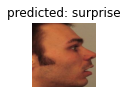

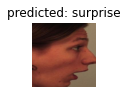

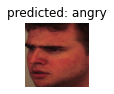

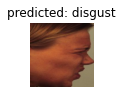

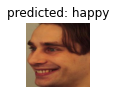

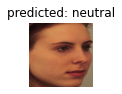

In [ ]:
visualize_model(model_deit_half, num_images=6)

**Confusion Matrix**

Text(0.5, 69.0, 'Predicted label')

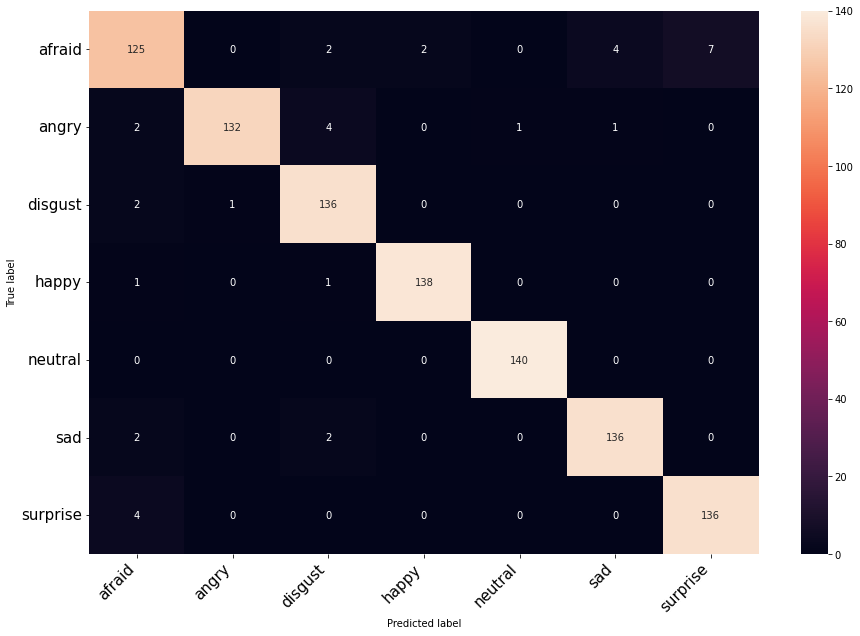

In [ ]:
nb_classes = 7
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_deit_half(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

class_names_val = class_names
df_cm = pd.DataFrame(confusion_matrix, index=class_names_val, columns=class_names_val).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} correct with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()

In [ ]:
check_accuracy(dataloaders['val'], model_load_cf)

**predictions**

In [ ]:
model_load = torch.load('/content/drive/MyDrive/KDEF/experiment_8/train_valid_exp8_100Epochs-epoch75.pt')
model_load.eval()

In [ ]:
#test image path

image = '/content/drive/MyDrive/CK+48/AF03SUHL.JPG'

im = Image.open(image).convert('RGB')

In [ ]:
img = data_transforms['val'](im).unsqueeze(0).to(device)

# compute the predictions
out = model_load(img)

# and convert them into probabilities
scores = torch.nn.functional.softmax(out, dim=-1)[0]

# finally get the index of the prediction with highest score
topk_scores, topk_label = torch.topk(scores, k=5, dim=-1)

for i in range(5):
  pred_name = class_names[topk_label[i]]
  print(f"Prediction index {i}: {pred_name:<25}, score: {topk_scores[i].item():.3f}")

Prediction index 0: angry                    , score: 0.808
Prediction index 1: happy                    , score: 0.171
Prediction index 2: disgust                  , score: 0.020
Prediction index 3: afraid                   , score: 0.001
Prediction index 4: neutral                  , score: 0.000
